In [1]:
import qiskit
from qiskit import *
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from math import pi
import os

In [2]:
# Creating registers with n qubits
n =7  # for a local backend n can go as up as 23, after that it raises a Memory Error
alice_qr = QuantumRegister(n, name='alice_qr')
bob_qr = QuantumRegister(n, name='bob_qr')
cr = ClassicalRegister(n, name='cr')

qc = QuantumCircuit(alice_qr, bob_qr, cr, name='QC')

In [3]:
# create entangled qubits
qc.h(alice_qr[0])
qc.cx(alice_qr[0], bob_qr[0])
qc.barrier()

In [4]:
# Generate a random number in the range of available qubits [0,2**n))
alice_key = np.random.randint(0, 2**n)
alice_key = np.binary_repr(alice_key, n)

In [5]:
print("Alice key:", alice_key)

Alice key: 1111101


In [6]:
# Apply X-gate to the first qubit if bit is 1
if alice_key[0] == '1':
    qc.x(alice_qr[0])

In [7]:
# Measure in Hadamard basis
qc.h(alice_qr[0])
qc.h(bob_qr[0])
qc.cx(alice_qr[0], bob_qr[0])
qc.h(alice_qr[0])
qc.measure(alice_qr[0], cr[0])
qc.measure(bob_qr[0], cr[1])

In [8]:
# Measure in the Z-basis
qc.z(alice_qr[1])
qc.x(alice_qr[1])
qc.cx(alice_qr[1], bob_qr[1])
qc.h(alice_qr[1])
qc.measure(alice_qr[1], cr[0])
qc.measure(bob_qr[1], cr[1])

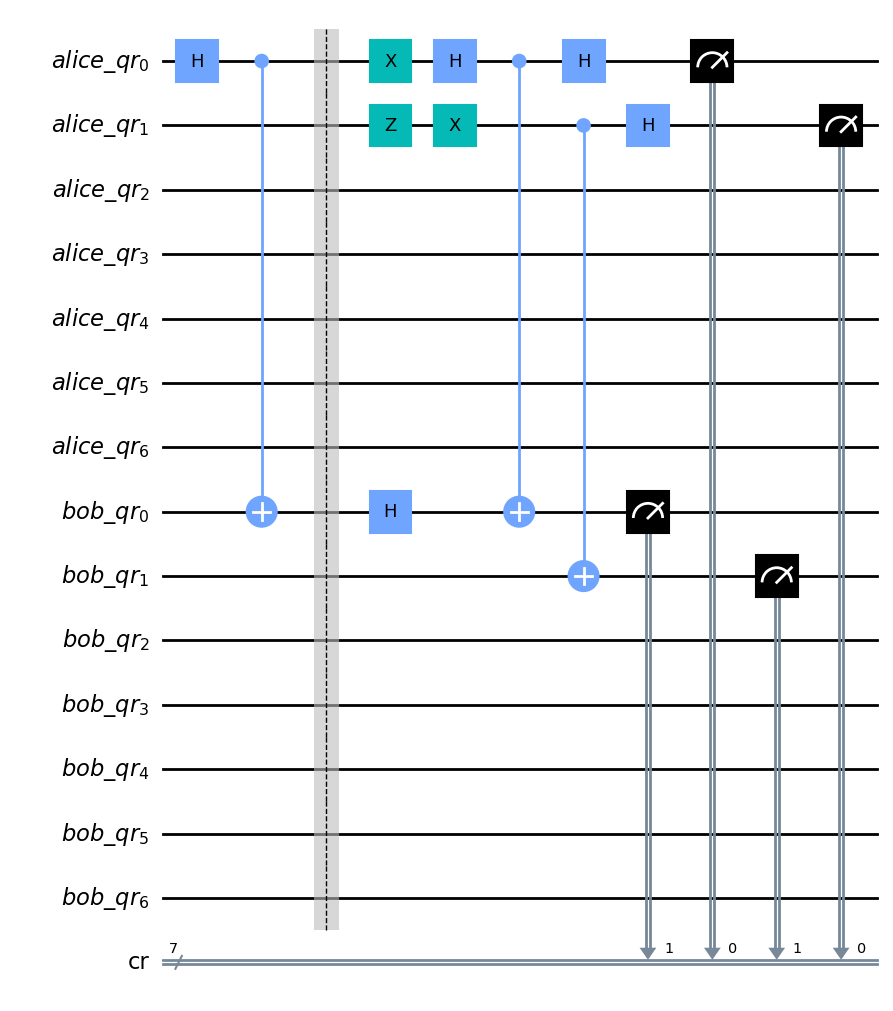

In [9]:
qc.draw(output='mpl')

In [10]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = simulator, shots = 4096).result()

In [11]:
# decode the key
bob_key = list(result.get_counts(qc))[0][::-1]
bob_key = ''.join(bob_key)
print("Bob key :", bob_key)

Bob key : 1100000


In [12]:
# compare basis and keys
if bob_key == alice_key:
    print("Keys match!")
else:
    print("Error: Keys do not match.")

Error: Keys do not match.


In [13]:
E91_key=bob_key[0]

In [14]:
def wordToBV(s) :
    #convert text to binary
    a_byte_array = bytearray(s, "utf8")
    byte_list = []


    for byte in a_byte_array:
        binary_representation = bin(byte)
        byte_list.append(binary_representation[9-n:])
        #chop off the "0b" at the beginning. can also truncate the binary to fit on a device with N qubits
        #binary has 2 extra digits for "0b", so it starts at 9 for our 7 bit operation. 

    print(byte_list)
    
    circuit_array = []
    
    length = len(byte_list) 
    
    for i in range(length):
    
        s = byte_list[i]


        #do all  this stuff for every letter

        # We need a circuit with n qubits, plus one ancilla qubit
        # Also need n classical bits to write the output to
        bv_circuit = QuantumCircuit(n+1, n)

        # put ancilla in state |->
        bv_circuit.h(n)
        bv_circuit.z(n)

        # Apply Hadamard gates before querying the oracle
        for i in range(n):
            bv_circuit.h(i)

        # Apply barrier 
        bv_circuit.barrier()

        # Apply the inner-product oracle
        s = s[::-1] # reverse s to fit qiskit's qubit ordering
        for q in range(n):
            if s[q] == '0':
                bv_circuit.i(q)
            else:
                bv_circuit.cx(q, n)

        # Apply barrier 
        bv_circuit.barrier()

        #Apply Hadamard gates after querying the oracle
        for i in range(n):
            bv_circuit.h(i)

        # Measurement
        for i in range(n):
            bv_circuit.measure(i, i)
            
        circuit_array.append(bv_circuit)

    
    return circuit_array

['1100010', '1101110', '1101101', '1101001', '1110100']


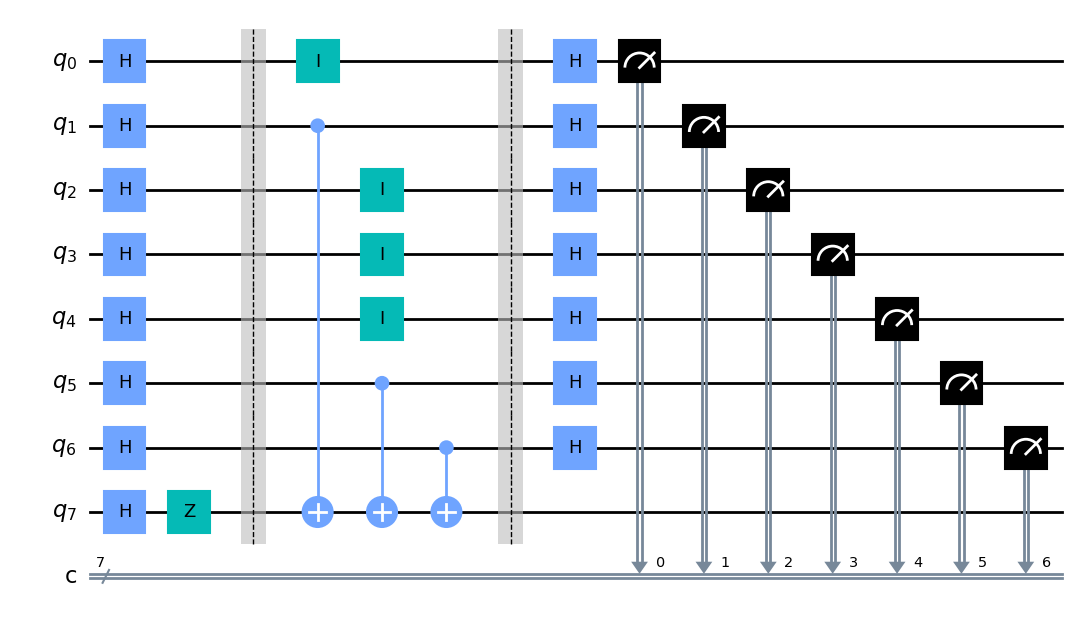

In [15]:
circuit_to_run = wordToBV('bnmit')#Secret Msg
circuit_to_run[0].draw(output='mpl')

In [16]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 4096
results = execute(circuit_to_run[::-1], backend=backend, shots=shots).result()
answer = results.get_counts()

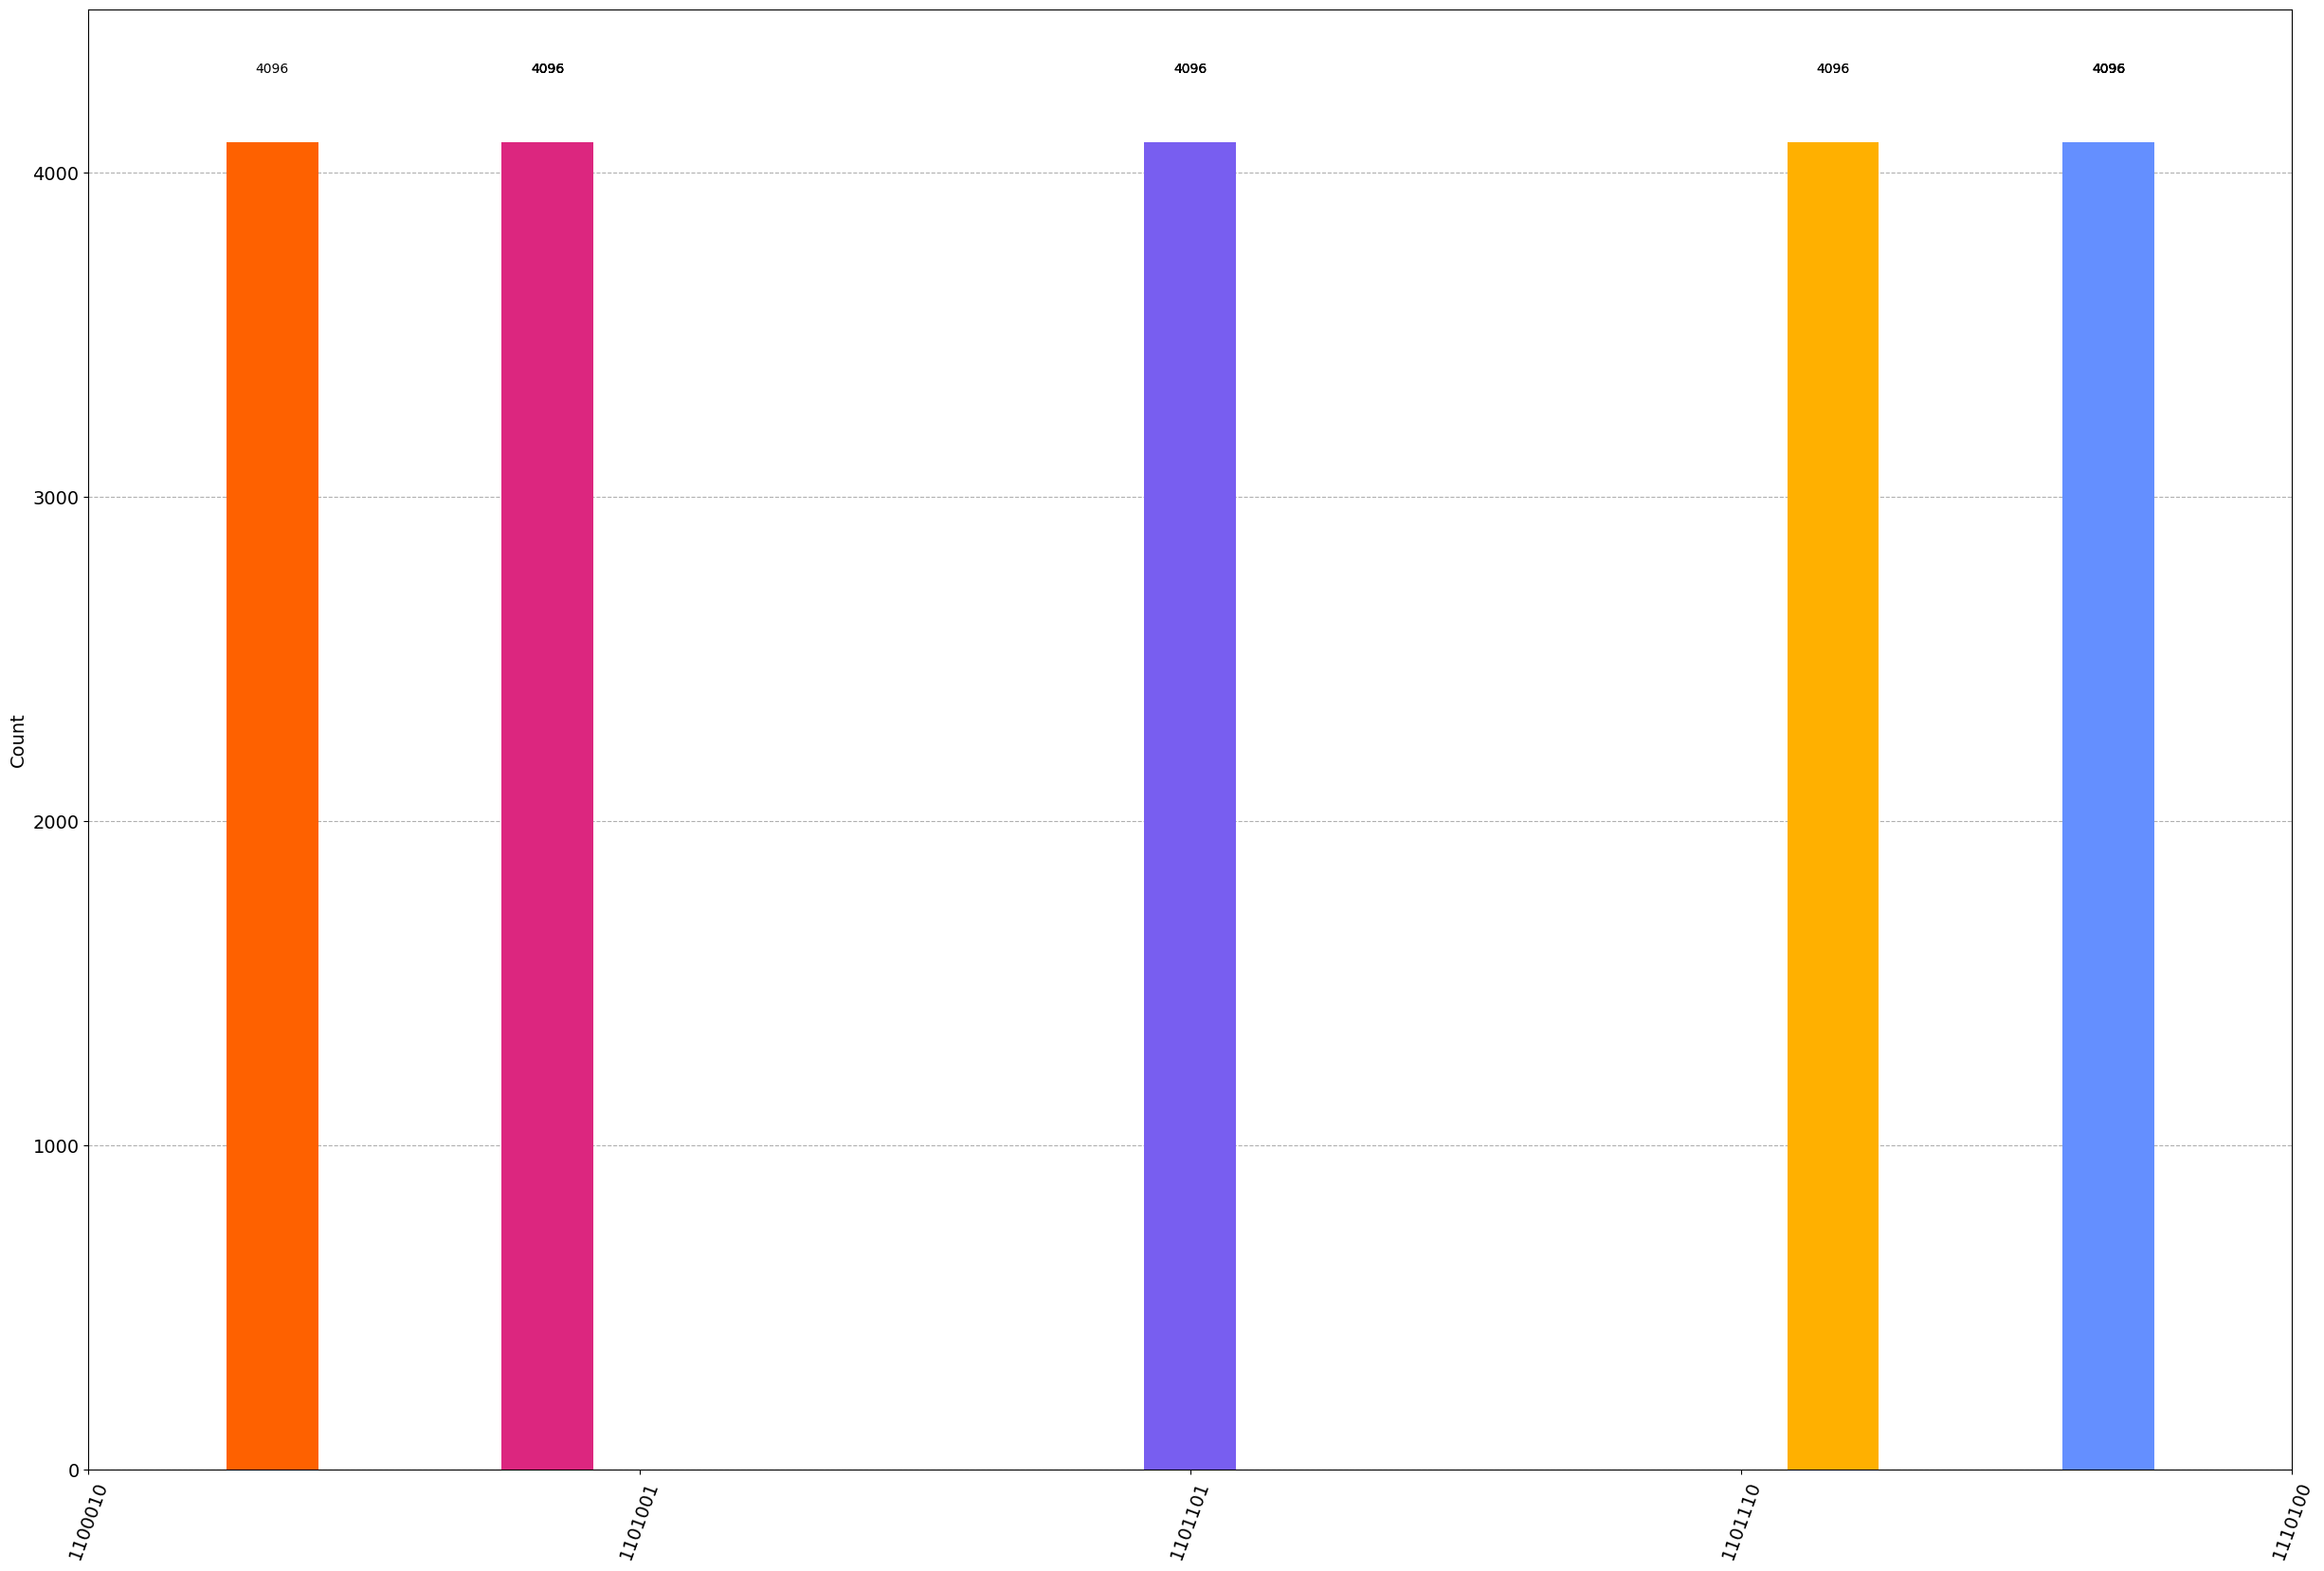

In [17]:
plot_histogram(answer,figsize=(30,20),)

In [18]:
def encrypt(E91_key, letter):
    """Calculates XOR"""
    b = int(E91_key, 2)
    x = sum([ord(i) for i in letter])
    return format(b ^ x, "b")


def stega_encoder(LM, carrier_msg):
    """Encodes LM bits message into carrier_msg"""
    message = ""
    size = len(LM[0])
    i = 0
    for j, bitstring in enumerate(LM):
        for k, digit in enumerate(bitstring):
            while (not carrier_msg[i].isalpha()):
                message += carrier_msg[i]
                i += 1

            if digit == "1":
                letter = carrier_msg[i].upper()
                message += letter
            else:
                message += carrier_msg[i]

            i += 1
    
    if i < len(carrier_msg):
        message += carrier_msg[i:]

    return message


def stega_decoder(new_carrier_msg, E91_key):
    """Decodes secret message from new_carrier_msg"""

    b = int(E91_key, 2)

    message = ""
    bitstring = ""
    for char in new_carrier_msg:
        if char.isalpha():
            if char.isupper():
                bitstring += "1"
            else:
                bitstring += "0"

        if len(bitstring) == 7:
            x = int(bitstring, 2)
            message += chr(b ^ x)
            bitstring = ""

    return message

In [19]:
for i in range(100, 1100):
    carrier_msg=chr(i)

In [20]:
str(carrier_msg)

'ы'

In [21]:
encrypt(E91_key,'bnmit')

'1000011011'

In [22]:
secret_msg='bnmit'
L=[]
for c in secret_msg:
    L.append(encrypt(E91_key,c))

In [23]:
carrier_msg='Bangalore is known as silicon city of india'

In [24]:
new_carrier_msg=stega_encoder(L, carrier_msg)

In [25]:
stega_decoder(new_carrier_msg, E91_key)

'bnmit'